# Demo

This notebook provides a simple demo of the basic filling algorithm.  We start off by loading all the libraries that we will need for our demo and setting the example data

In [1]:
# setup the path so it can find popfill
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

mask_file = "../data/mask_clip.tif"
population_file = "../data/pop_clip.tif"


def plot_bool(data):
    print(np.sum(data))
    plt.imshow(data, interpolation='none', cmap='gray')

def plot_real(data):
    p = data.copy()
    plt.imshow(data, cmap='gray', interpolation='none')
    plt.colorbar()



# Load & Process Data

Next, we load the data and run the filling algorithm.

In [2]:
import popfill.loader
loader = popfill.loader.PopulationLoader()
mask, population = loader.load(mask_file, population_file)

import popfill.kernel
filler = popfill.kernel.Basic(mask.data, population.data)
new_counts = filler.fill()

# Some Visual Inspection

Lets look at a few peices of data.  First, lets look at the pixels with data that should be moved in the final output.

58


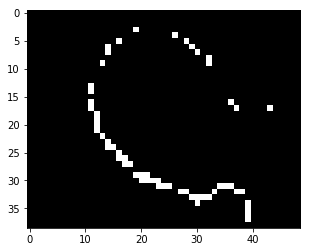

In [3]:
plot_bool(filler.to_remove())

Next, we identify all the pixels that should have data added in the final output

1


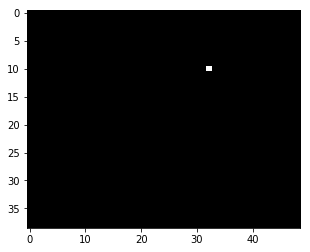

In [4]:
plot_bool(filler.to_add())

Next, we can look at the resulting image.

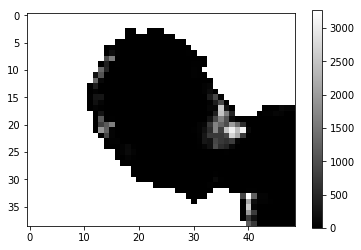

In [5]:
plot_real(new_counts)

# Examining the difference

Finally, we take a look at the difference between our updated population and the original population.  The figure shows pixels that have lost population.  Those pixels were in the region to be removed.  Also note that we cannot see anything for the region that was added to.  This is because `np.nan - <any int>` is `np.nan`

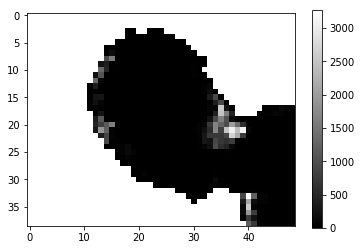

In [6]:
plot_real(population.data)

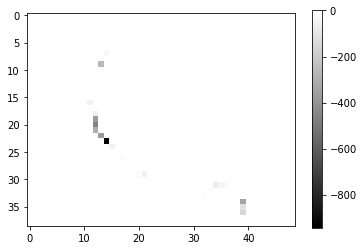

In [7]:
plot_real(new_counts-population.data)

In [53]:
def matsolve(data,mask,alpha):
    '''matrix realization of population filling.  data is np float, mask is np bool, regularization alpha'''
    # flatten arrays
    dims = data.shape
    n1 = dims[0]
    n2 = dims[1]
    d = data.flatten()
    m2 = mask.flatten()
    # create intial mask
    m0 = d == d
    # size of arrays
    n = d.size
    # remove nan
    for i in range(n):
        if m0[i] == False:
            d[i] = 0
    # initialize matrix
    A = lil_matrix((n, n), dtype=float)
    # loop through indexes
    for i in range(n):
        # determine indeces
        ix = i%n1
        iy = (i-ix)/n2
        # check to see if the shape is the same
        if m0[i] == m2[i]:
            A[i,i] = 1+alpha
        else:
            A[i,i] = alpha
            if m2[i] == True:
                # new land
                A[i,i] = A[i,i]+1
                k = 0
                num = 0
                conlst = []
                while num == 0:
                    k = k+1
                    for i2 in range(2*k+1):
                        for i1 in range(2*k+1):
                            deldex = (i2-k)*n1+(i1-k)
                            if n-deldex < 0:
                                continue
                            if n-deldex > n-1:
                                continue
                            if m0[n-deldex] == True:
                                conlst.append(n-deldex)
                                num = num+1
                    if k > 10:
                        break
                for i3 in range(len(conlst)):
#                    A[conlst[i3],i] = -1/num + A[conlst[i3],i]
                    A[i,conlst[i3]] = 1/num + A[i,conlst[i3]]
            else:
                # new water
                k = 0
                num = 0
                conlst = []
                while num == 0:
                    k = k+1
                    for i2 in range(2*k+1):
                        for i1 in range(2*k+1):
                            deldex = (i2-k)*n1+(i1-k)
                            if n-deldex < 0:
                                continue
                            if n-deldex > n-1:
                                continue
                            if m2[n-deldex] == True:
                                conlst.append(n-deldex)
                                num = num+1
                    if k > 10:
                        break
                for i3 in range(len(conlst)):
                    A[conlst[i3],i] = 1/num + A[conlst[i3],i]
#    A[n-1,:] = 0
#    A[n-1,n-1] = 1+alpha
#    d[n-1] = 0
    A1 = A.tocsr()
    AT = A1.T
    penrose = A1.dot(AT)
    b = spsolve(penrose,AT.dot(d.T))
    b = spsolve(A1,d)
    b = A1.dot(d.T)
    # write back nan
    for i in range(n):
        if b2 == False:
            b[i] = np.nan
    bata = np.reshape(b,(n1,n2))
#    bata = np.copy(data)
#    for i2 in range(n2):
#        for i1 in range(n1):
#            index = i2*n1 + i1
#            bata[i1,i2] = b[index]
    return bata;

In [54]:
xlv = matsolve(population.data,mask.data,.001)
plot_real(xlv)
#plot_real(population.data)

NameError: name 'b2' is not defined

In [44]:
population.data.flatten()


array([      nan,       nan,       nan, ..., 0.       , 0.       ,
       2.8030999], dtype=float32)

In [52]:
a = 1/0
print(a+1)

ZeroDivisionError: division by zero